## Configure qiskit_dynamics to use JAX

In [1]:
import os
os.environ['JAX_JIT_PJIT_API_MERGE'] = '0'

# configure jax to use 64 bit mode
import jax
jax.config.update("jax_enable_x64", True)

# tell JAX we are using CPU
jax.config.update('jax_platform_name', 'cpu')

# import Array and set default backend
from qiskit_dynamics.array import Array
Array.set_default_backend('jax')

import jax.numpy as jnp
import numpy as np

## Construct discretized basis for pulse signal

### 1. Chebyshev Basis 

In [2]:
import jax.numpy as jnp
from numpy.polynomial.chebyshev import Chebyshev

def discretized_chebyshev(degree, n, T):
    dt = T / n
    coeffs = jnp.zeros(degree + 1)
    coeffs = coeffs.at[-1].set(1.)

    return jnp.array(Chebyshev(coeffs, domain=[0, T], window=[-1,+1])(jnp.linspace(0, T-dt, n) + dt/2 ))

def discretized_chebyshev_basis(max_degree, n, T):
    vals = list(range(max_degree + 1))
    disc_leg_map = map(lambda deg: discretized_chebyshev(deg, n, T), vals)
    
    return jnp.array(list(disc_leg_map))

## Define single qubit hamiltonian
Consider the lab-frame Hamiltonian:

$$ H(t) = 2 \pi \nu a^\dagger a + \pi \alpha a^\dagger a(a^\dagger a - 1) + 2 \pi r s(t)(a + a^\dagger)$$

with:

- $a$, $a^\dagger$ the annihilation/creation operators
- $\nu$ the qubit frequency, $\alpha$ the anharmonicity, and $r$ the drive strength
- $s(t)$ a control signal which may depend on some list of parameters

For this demo we will add add uncertainties to the frequency and drive strengh $c = (c_0, c_1)$:

$$H(t, c) = 2 \pi \nu (1 + c_0) a^\dagger a + \pi \alpha a^\dagger a(a^\dagger a - 1) + 2 \pi r (1 + c_1) s(t)(a + a^\dagger)$$

In [3]:
dim = 4   #number of levels

v=5.034449185334494
anharm = -0.3428091445
r = 0.11837211845961955

a = np.diag(np.sqrt(np.arange(1, dim)), 1)
adag = np.diag(np.sqrt(np.arange(1, dim)), -1)
N = np.diag(np.arange(dim))
X = a + adag

# static part
static_hamiltonian = 2 * np.pi * v * N + np.pi * anharm * N * (N - np.eye(dim))
# drive term
drive_hamiltonian = 2 * np.pi * r * X

## Rotating frames in dynamics

We will work in the rotating frame of the static Hamiltonian $H_s = 2 \pi \nu a^\dagger a + \pi \alpha a^\dagger a(a^\dagger a - 1)$. I.e. our Hamiltonian will actually be:

$$\tilde{H}(t, c) = 2 \pi \nu c_0 \tilde{N}(t) + 2 \pi r (1 + c_1) s(t)\tilde{X}(t),$$

where
- $\tilde{N}(t) = e^{iH_st}(a^\dagger a)e^{-iH_st}$
- $\tilde{X}(t) = e^{iH_st}(a + a^\dagger)e^{-iH_st}$

In [4]:
from qiskit_dynamics.models import RotatingFrame

rotating_frame = RotatingFrame(static_hamiltonian)

## Construct DiscreteSignal 

### Define signal parameters and basis

Here, we are making sure that sampling is done at half the backend (backend sampling = 0.22222ns, our sampling 0.11111 ns)

In [5]:
num_params=24    ##Parameter space dimension
max_deg=int((num_params)/2 -1)    ##max degree of chebyshev basis
T=5.27*0.5/r       ##Domain of basis function
n=200         ##number of samples, affects the Total duration of the pulse
basis=jnp.concatenate((jnp.zeros((int(num_params/2),1)),discretized_chebyshev_basis(int(num_params/2)-1, n-1, T)),1) 
##creating Chebyshev basis and adding zero pad in the begining

T_gate=np.ceil(3*T-2*T/n)   ##Convolution adds some samples. Final T_gate is equal to this.

### Define covolution function (gaussian) to smooth the signal
Convolution is applied on both sides (start and end) of the signal. I Defined an array with gaussian values and then convolved my pulse using it. 

In [6]:
from qiskit_dynamics.signals import Convolution
def gaus_left(t):
    sigma = 8
    delt = 0.015
    return 2.*delt/np.sqrt(2.*np.pi*sigma**2)*np.exp(-t**2/(2*sigma**2))
def gaus_right(t):
    sigma = 8
    delt = 0.015
    return 2.*delt/np.sqrt(2.*np.pi*sigma**2)*np.exp(-(t-T)**2/(2*sigma**2))

convolution_left =jnp.array([gaus_left(x) for x in (np.linspace(0, T, n) +T/(2*n))])
convolution_right=jnp.array([gaus_right(x) for x in (np.linspace(0, T, n) +T/(2*n))])

### Generate convolved signal with carrier freq 'v' 
Here, first $n$ terms that are being passed as $\textit{params}$ are real part of signal and last $n$ terms are complex part (i.e. signal on Y component). I have bounded the function after convolving it.

In [7]:
from qiskit_dynamics import DiscreteSignal
from jax.scipy.signal import convolve
def construct_smooth_sig(params):
    sig=jnp.sum(jnp.multiply(basis, params[0:,None]),0)
    smooth_sig=convolve(convolve(sig,convolution_left),convolution_right)
    sig_bounded=jnp.arctan(smooth_sig) /(np.pi / 2)
    return sig_bounded

def get_parameterized_signal(params):
    real_sig=construct_smooth_sig(params[0:(max_deg+1)])
    comp_sig=construct_smooth_sig(params[max_deg+1:(2*(max_deg+1))])
    smooth_signal=DiscreteSignal(T/n, real_sig+(1j * comp_sig), carrier_freq=v)
    return smooth_signal

### Test Signal

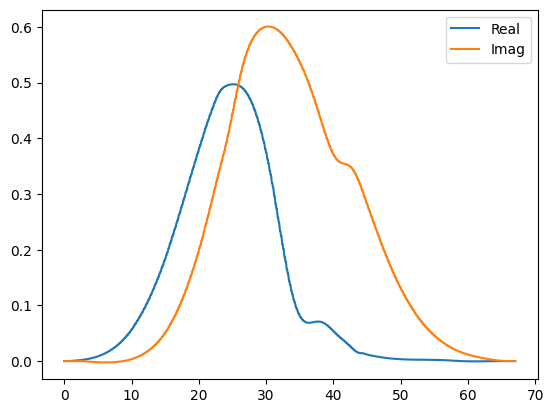

In [8]:
test_sig=get_parameterized_signal(np.random.uniform(-100,100,24))
test_sig.draw(t0=0,tf=T_gate,n=1000, function='envelope')

## Computing perturbation theory terms

### Constructing generators from signal parameters

In [9]:
iX = -1j * 2 * np.pi * r * Array(X)
iN = -1j * 2 * np.pi * v * Array(N)

def construct_generator_parts(params):
    
    sig = get_parameterized_signal(params)
    #sig.phase=phase
    
    def unperturbed_generator(t):
        return (sig(t) * rotating_frame.operator_into_frame(t, iX)).data
    
    def perturb0(t):
        return (rotating_frame.operator_into_frame(t, iN)).data
    
    def perturb1(t):                     ##Same as unperturbed
        return (sig(t) * rotating_frame.operator_into_frame(t, iX)).data
    
    return unperturbed_generator, perturb0, perturb1

### Initializing exact and perturbation solver
I have used dyson expansion instead of magnus (are the results affected by which expansion we use?).

In [10]:
from qiskit_dynamics import solve_lmde
from qiskit_dynamics.perturbation import solve_lmde_perturbation

def solve(model_params, control_params):
    generator, perturb0, perturb1 = construct_generator_parts(control_params)
    
    full_generator = lambda t: generator(t) + model_params[0] * perturb0(t) + model_params[1] * perturb1(t)
    
    results = solve_lmde(
        generator=full_generator,
        t_span=[0, T_gate],
        y0=np.eye(dim, dtype=complex),
        method='jax_odeint',
        atol=1e-10, rtol=1e-10
    )
    return results.y[-1]

def solve_w_perturbation(params):
    generator, perturb0, perturb1 = construct_generator_parts(params)
    
    results = solve_lmde_perturbation(
        perturbations=[perturb0, perturb1],
        t_span=[0, T_gate],
        expansion_method='dyson',
        expansion_order=1,
        generator=generator,
        integration_method='jax_odeint',
        atol=1e-10, rtol=1e-10
    )

    return results.y[-1], results.perturbation_data.get_item([0])[-1], results.perturbation_data.get_item([1])[-1]


## Optimizing

For fidelity we will optimise a $\pi$ gate acting around arbitrary axis in X-Y plane. For this we essentially want to maximize the norm of the projection of the unitary onto the X-Y plane. The norm squared of the projection is equal to the maximization 

$$F(U) = |\langle X, e^{-i \phi Z}Ue^{i \phi Z}\rangle|^2=\frac{|\mathrm{Tr} (e^{-i \phi Z}Xe^{i \phi Z} U)|^2}{4}$$

where it is necessary to restrict $U$ to the computational subspace before doing this. When computing fidelity, we use $U(T, 0)$, the final unperturbed unitary.

For robustness, I am using the norms of the operators in a first order dyson expansion. 

For robustness in dimensions, I am integrating leakage terms in the $\tilde{H}^{drive}$ and minimising it. Essentially I am calculating:

$$Leakage=\sum_{n>1}|\int_0^T dt \tilde{H}^{d}_{0n}|+\sum_{n>1}|\int_0^T dt \tilde{H}^{d}_{1n}|$$




In [11]:
vals=jnp.linspace(0,T_gate,400)+(T_gate/800)

def fidelity_pi(U):
    U = Array(U[0:2,0:2])
    U = U - np.diag(np.diag(U))
    return np.abs((U.conj() * U).sum())**2 / 4.


def fidelity_pihalf(U):       ##Quick and dirty pi/2. We need to change it to include more general pi/2. Diagonals 
    U=Array(U[0:2,0:2])       ##are 1/sqrt(2) and off diags a and b are related as b= -a.conj()   
    return np.abs((sx * U).sum())**2 / 4


def traceless_hs_norm(A):
    A = Array(A[:, 0:2])
    return np.linalg.norm(A - A.trace() * np.eye(dim, 2, dtype=complex) / 2.)

def leakage_norm(gen):
    matrices = (jax.vmap(lambda x: gen(x), in_axes=0)(vals))*(T_gate/(400-1))
    leakage = jnp.sum(jnp.abs(jnp.tril(jnp.sum(matrices,axis=0)[:,0:2])[2:,:]))
    return leakage

### Target as an array
This function returns individual targets as:

[gate_fidelity, freq_robustness, amplitude_robustness, leakage]

In [12]:
def target_as_array(params):
    
    gen, _ , _ = construct_generator_parts(params)
    
    U, dU0, dU1 = solve_w_perturbation(params)
    fid = fidelity_pi(U).data                     ##change here to optimize pi/2
    robust0 = traceless_hs_norm(dU0).data / (2 * np.pi * v * T_gate)
    robust1 = traceless_hs_norm(dU1).data / (2 * np.pi * r * T_gate)
    leakage=leakage_norm(gen) / (2*np.pi*r*T_gate)
    
    target=jnp.array([1-fid, robust0, robust1, leakage])
    
    return target

### Objective with weights for targets

In [13]:
##My approach was to get amplitude robustness first (which is hard to get) and then minimize fidelity. 
##I used to start with a target which looked something like [40,5,100,1]. 
##After that I increased target for freq and then fidelity.


def objective(params):
    target=target_as_array(params)
    weights=jnp.array([130, 40, 80,1])
    return jnp.dot(weights, target)

### Using JAX to optimize

In [14]:
from jax import jit, value_and_grad, vmap
from scipy.optimize import minimize

In [15]:
import qiskit_dynamics as qd
import scipy as sp

jit_grad_obj = jit(value_and_grad(lambda p: objective(p)))
jit_target_array=jit(lambda x: target_as_array(x))

def jax_grad_obj(params):
    values = jit_grad_obj(params)
    print(jit_target_array(params))
    #print(params)
    return (values[0], values[1])

In [16]:
%time result = sp.optimize.minimize(jax_grad_obj,np.random.uniform(-100,100,24),method='BFGS',jac=True,tol=10e-8,options={'disp': False, 'maxiter': 30})

[1.01272706e-01 1.63764255e-01 1.38163643e-01 1.08992643e-04]
[4.99809759e-02 1.54603616e-01 1.36200641e-01 1.09450140e-04]
[4.39478448e-04 1.52946808e-01 1.31421705e-01 1.10535240e-04]
[1.99501034e-04 1.51988848e-01 1.31774891e-01 1.10452918e-04]
[1.96308205e-04 1.51995468e-01 1.31761871e-01 1.10452429e-04]
[1.91766028e-04 1.52022605e-01 1.31709788e-01 1.10450452e-04]
[1.98615370e-04 1.51873316e-01 1.31659359e-01 1.10426654e-04]
[2.20515745e-04 1.51481307e-01 1.31600034e-01 1.10372455e-04]
[4.58919794e-04 1.49847144e-01 1.31361845e-01 1.10149975e-04]
[1.24435294e-03 1.45098164e-01 1.30996161e-01 1.09540761e-04]
[2.86046093e-03 1.35878630e-01 1.30546145e-01 1.08358246e-04]
[6.02186199e-03 1.19741848e-01 1.29998558e-01 1.06176028e-04]
[7.36922113e-03 1.07138142e-01 1.29888079e-01 1.04160979e-04]
[4.50099877e-03 1.03157913e-01 1.30479173e-01 1.02782787e-04]
[1.66192991e-03 1.06424472e-01 1.31254405e-01 1.02696601e-04]
[1.81145100e-03 1.04548590e-01 1.31396845e-01 1.02330290e-04]
[1.51427

In [17]:
result

  message: Maximum number of iterations has been exceeded.
  success: False
   status: 1
      fun: 14.0788137094746
        x: [-2.147e+01  1.004e+02 ...  4.624e+01 -6.643e+01]
      nit: 30
      jac: [ 2.265e-02  2.234e-02 ...  6.423e-04  5.142e-04]
 hess_inv: [[ 8.605e+01 -7.680e+01 ...  3.809e+00  1.114e+01]
            [-7.680e+01  8.108e+01 ... -4.183e+00 -9.681e+00]
            ...
            [ 3.809e+00 -4.183e+00 ...  1.227e+00  4.993e-01]
            [ 1.114e+01 -9.681e+00 ...  4.993e-01  2.587e+00]]
     nfev: 36
     njev: 36

### Best $\pi$ Pulse

In [18]:
c0=np.array([73.62308921,3.19223441,161.18759437,-150.57940717,288.15355022,
  -59.53688782, -495.42943658, -157.63258942,  -96.47497426,  -32.98274664,
  122.59149652,  -24.04210008,  158.23636227,  -37.98345367,  459.96185924,
  124.37995979,  334.17043406, -120.86549574, -717.48286267, -163.53566059,
  -11.1661289,   196.79637232,  -46.19198142,  -24.07874067])

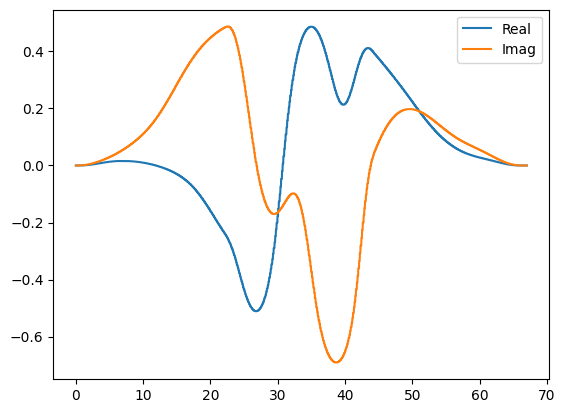

In [19]:
get_parameterized_signal(c0).draw(t0=0,tf=T_gate,n=2000, function='envelope')

## Fourier Transform

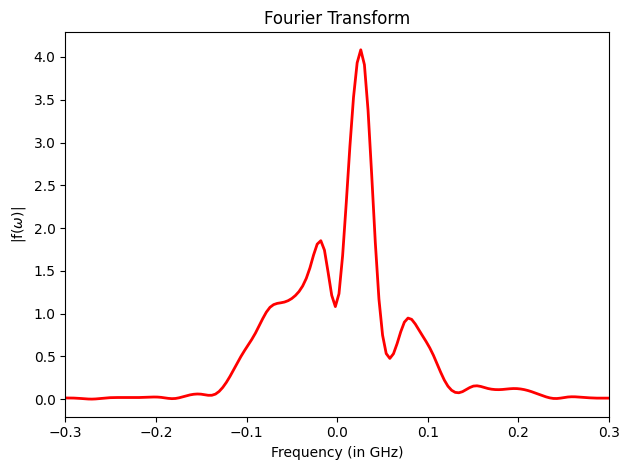

In [20]:
%matplotlib inline
from matplotlib import pyplot as plt
from numpy.fft import fft, fftfreq
from scipy import interpolate
# sampling rate
sr = 300
# sampling interval
t = np.linspace(0,66.4,sr)
y= lambda k:get_parameterized_signal(c0).envelope(k).data   ##Put the pulse parameters here
f_real=lambda m: np.array([y(m)])[0]

gr = f_real(t)

X = fft(gr)/np.sqrt(len(gr))

freq=fftfreq(sr, d=66.4/299)

order = np.argsort(freq)
freq = np.array(freq)[order]
X = np.array(X)[order]


x_new = np.linspace(-1,1, 500)
bspline1 = interpolate.make_interp_spline(freq, np.abs(X))
y_new1 = bspline1(x_new)
plt.plot(x_new,y_new1, linestyle="-", marker = '', linewidth=2,color='r')

plt.xlim(-0.3,0.3)

plt.title("Fourier Transform")
plt.xlabel('Frequency (in GHz)')
plt.ylabel(r'|f($\omega$)|')
plt.tight_layout()
plt.savefig('fig.pdf')


In [21]:
from qiskit.quantum_info import average_gate_fidelity
from qiskit.quantum_info import Operator

U = solve(np.array([0.,0.]), c0)   ##c0 is pusle parameter

op1=Operator(np.array(U[0:2,0:2]), input_dims=2, output_dims=2)


def maximise_fid(phi):
    target=jnp.array([[0,np.exp(-1j*phi)],[np.exp(1j*phi),0]],dtype='complex')
    op2=Operator(np.array(target), input_dims=2, output_dims=2)
    obj=average_gate_fidelity(op1, target=op2)
    return 1-obj
    

%time result = sp.optimize.minimize(maximise_fid, 0. ,method='BFGS',tol=10e-12)
result

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 2) + inhomogeneous part.

  message: Maximum number of iterations has been exceeded.
  success: False
   status: 1
      fun: 14.0788137094746
        x: [-2.147e+01  1.004e+02 ...  4.624e+01 -6.643e+01]
      nit: 30
      jac: [ 2.265e-02  2.234e-02 ...  6.423e-04  5.142e-04]
 hess_inv: [[ 8.605e+01 -7.680e+01 ...  3.809e+00  1.114e+01]
            [-7.680e+01  8.108e+01 ... -4.183e+00 -9.681e+00]
            ...
            [ 3.809e+00 -4.183e+00 ...  1.227e+00  4.993e-01]
            [ 1.114e+01 -9.681e+00 ...  4.993e-01  2.587e+00]]
     nfev: 36
     njev: 36

## Checking Robustness

### Frequency Robustness

In [24]:
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigsh
from scipy.optimize import curve_fit



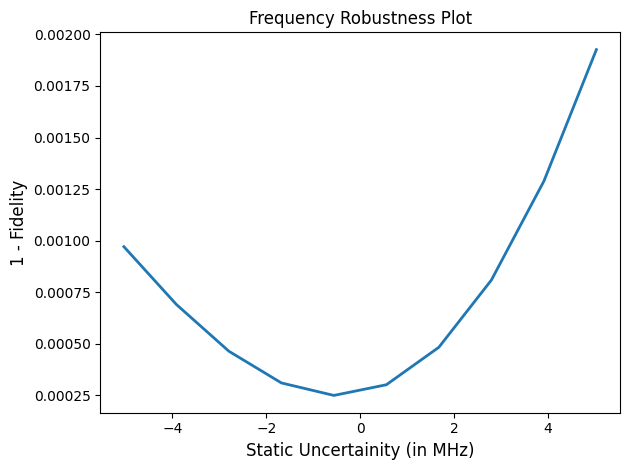

In [25]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rc('axes', labelsize=12)
def fid(model_params, control_params):
    U = solve(model_params, control_params)
    return 1 - fidelity_pi(U).data
jit_fid = jit(lambda p: fid(p, c0))                ##Pulse paramters
model_params_dir = jnp.array([1., 0.])
eps0 = jnp.linspace(-0.001, 0.001, 10)            
fid_values=[jit_fid(x) for x in jnp.outer(eps0, model_params_dir)]
plt.plot(eps0*v*1e3, fid_values, linestyle="-", marker = '', linewidth=2)
plt.title("Frequency Robustness Plot")
plt.xlabel('Static Uncertainity (in MHz)')
plt.ylabel('1 - Fidelity')
plt.tight_layout()

### Amplitude Robustness

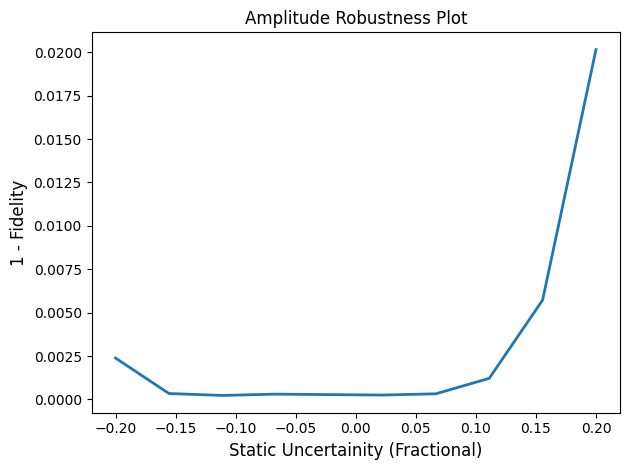

In [26]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rc('axes', labelsize=12)
def fid(model_params, control_params):
    U = solve(model_params, control_params)
    return 1 - fidelity_pi(U).data
jit_fid_a = jit(lambda p: fid(p, c0))
model_params_dir = jnp.array([0., 1.])
eps1 = jnp.linspace(-0.2, 0.2, 10)
fid_values_a=[jit_fid_a(p) for p in jnp.outer(eps1, model_params_dir)]
plt.plot(eps1, fid_values_a, linestyle="-", marker = '', linewidth=2)
plt.title("Amplitude Robustness Plot")
plt.xlabel('Static Uncertainity (Fractional)')
plt.ylabel('1 - Fidelity')
plt.tight_layout()

##  Compute Jacobian 

Since jacrev only takes real values, we will vectorize the unitary to yield flattened real value function.

In [27]:
from jax import jacrev

points=jnp.vstack((np.linspace(-0.00001,0.00001,4),np.linspace(0.01,0.03,4)))   ##Points at which to compute jacobian
    
def real_solve(control_params):
    U= jnp.array([solve(x, control_params) for x in points.T])
    U = U[:,0:2,0:2]
    return jnp.array([U.real, U.imag]).flatten()

jacobian = jacrev(real_solve)(c0)

In [28]:
u, s, vh = jnp.linalg.svd(jacobian)
s


Array([1.70568057e-01, 6.29324287e-02, 4.05659133e-02, 9.83804948e-03,
       6.88931621e-04, 4.04788105e-04, 5.26860349e-05, 1.24848058e-06,
       1.10131044e-06, 7.91462497e-07, 4.47276985e-07, 2.47974553e-07,
       1.40650200e-07, 2.61032421e-08, 1.02667508e-08, 7.22105616e-09,
       2.14523717e-09, 4.34013668e-10, 2.23939846e-10, 1.08965034e-10,
       7.68871196e-11, 3.82714224e-11, 1.59541818e-11, 6.94555907e-12],      dtype=float64)

In [29]:
cal_num = 4
cal_direc = vh[:cal_num]
cal_direc

Array([[-4.70763576e-01,  4.84791130e-02,  1.84017921e-01,
        -1.90718915e-02,  2.48564961e-02, -1.37757661e-02,
         2.90443214e-03, -5.45854235e-03,  5.83764182e-03,
        -1.02048365e-03,  3.28841507e-03, -1.96304201e-03,
         8.06021777e-01, -3.44248919e-04, -2.98444177e-01,
         1.48588232e-02, -3.33803883e-02, -1.27922291e-02,
        -2.26454989e-02, -5.08709861e-04, -9.44473104e-03,
         7.61083570e-04, -8.20685830e-03, -6.51644400e-04],
       [-6.14172749e-01,  2.34022891e-01,  5.06157040e-01,
        -2.38620341e-01, -1.70181996e-01,  3.33452020e-02,
         3.50741564e-03, -8.80198011e-03, -1.00053410e-02,
        -3.68067167e-03, -6.33445267e-03, -3.10225220e-03,
        -4.18140227e-01, -1.40010498e-02,  1.80425420e-01,
        -1.04295180e-01, -9.91769252e-03,  7.42487052e-02,
         1.52006780e-02,  1.12144127e-02,  3.97475698e-03,
         7.97672687e-03,  5.18820501e-03,  4.58439746e-03],
       [-4.26052168e-01, -4.14576218e-01, -2.66374624e

### Plot of Calibration direction

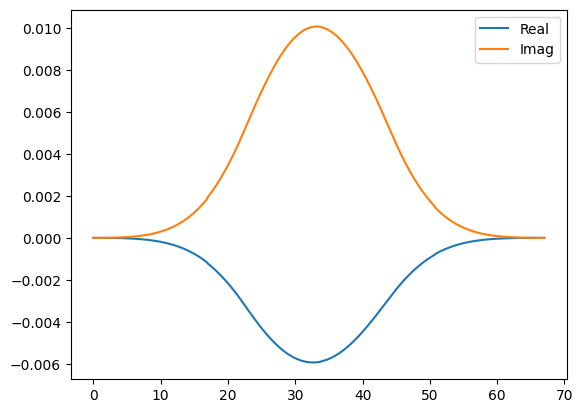

In [30]:
cal_sig = get_parameterized_signal(cal_direc[0])
cal_sig.draw(0., T_gate, 300, function='envelope')

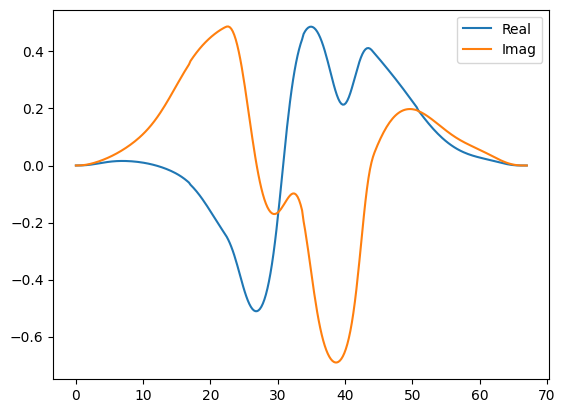

In [31]:
cal_sig = get_parameterized_signal(c0)
cal_sig.draw(0., T_gate, 300, function='envelope')

## Re-optimisation in singular vector directions

In [32]:
from jax.scipy.optimize import minimize

def run_calibration(model_params, c0, cal_direc):
    
    def cal_obj(x):
        U = solve(model_params, c0 + jnp.tensordot(x, cal_direc, axes=1))
        return 1 - fidelity_pi(U).data

    results = minimize(cal_obj, x0=np.zeros(len(cal_direc), dtype=float), method='BFGS',options={'maxiter': 120})
    return results

jit_cal = jit(lambda mp: run_calibration(mp, c0, cal_direc))

### Frequency

In [33]:
model_params_dir = jnp.array([1., 0.])
results0 = [jit_cal(mp) for mp in jnp.outer(eps0, model_params_dir)]

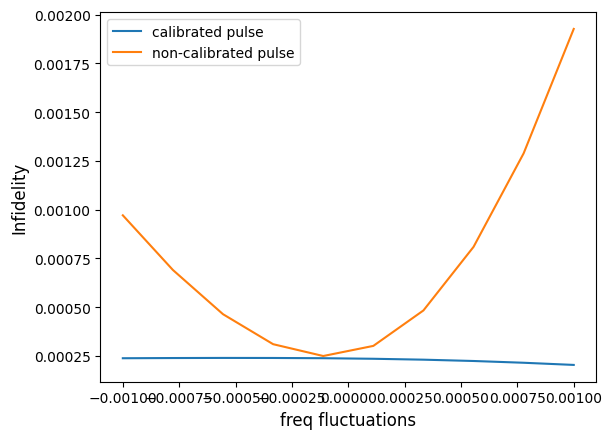

In [34]:
plt.plot(eps0, [results0[i].fun for i in range(len(eps0))], label='calibrated pulse')
plt.plot(eps0, fid_values, label='non-calibrated pulse')
plt.xlabel('freq fluctuations')
plt.ylabel('Infidelity')
plt.legend()

### Amplitude

In [35]:
model_params_dir = jnp.array([0., 1.])
results1 = [jit_cal(mp) for mp in jnp.outer(eps1, model_params_dir)]

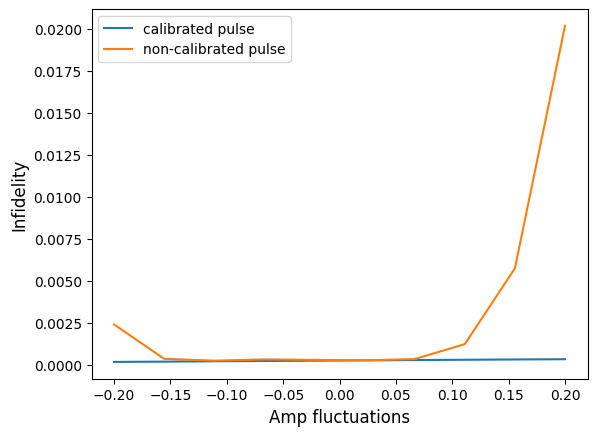

In [37]:
plt.plot(eps1, [results1[i].fun for i in range(len(eps1))], label='calibrated pulse')
plt.plot(eps1, fid_values_a, label='non-calibrated pulse')
plt.xlabel('Amp fluctuations')
plt.ylabel('Infidelity')
plt.legend()